# Toy-model Ablation Study - Results Processing

In [1]:
import os
import pickle
import pandas as pd
import numpy as np

import plotnine as p9

In [2]:
config_names = [
    #"initial",
    #"with_time",
    #"with_time_with_phospho",
    #"with_time_with_phospho_with_bcell",
    #"with_all",
    "with_all_hiddenlayers_in_cell",
    #"random"
]

results_folder = os.path.join("results", "ablation_study_res")

train_data_list = []
train_metrics_list = []
test_data_list = []
test_metrics_list = []

# Loop over configuration names to load each file
for name in config_names:
    # File name format: "cv_results_{config}.pkl"
    filename = f"cv_results_{name}.pkl"
    filepath = os.path.join(results_folder, filename)
    print(f"Loading file: {filepath}")
    # Load the cv_results list from each file
    with open(filepath, "rb") as f:
        cv_results = pickle.load(f)
    
    # Each file is a list of folds (each fold is a dictionary)
    for fold_dict in cv_results:
        cv_set = fold_dict["fold"]  # fold+1 provided in the dictionary
        
        train_df = fold_dict["train"]["data"].copy()
        train_df["CV_set"] = cv_set
        train_df["config"] = name
        train_data_list.append(train_df)
        
        train_metrics_list.append({
            "CV_set": cv_set,
            "config": name,
            "train_pearson": fold_dict["train"]["pearson"],
            "training_time": fold_dict["train"]["training_time"]
        })
        
        test_df = fold_dict["test"]["data"].copy()
        test_df["CV_set"] = cv_set
        test_df["config"] = name
        test_data_list.append(test_df)
        
        test_metrics_list.append({
            "CV_set": cv_set,
            "config": name,
            "test_pearson": fold_dict["test"]["pearson"]
        })

# concatenate all collected dataframes/metrics
train_data_concat = pd.concat(train_data_list, ignore_index=True)
train_metrics_df = pd.DataFrame(train_metrics_list)
test_data_concat = pd.concat(test_data_list, ignore_index=True)
test_metrics_df = pd.DataFrame(test_metrics_list)

Loading file: results\ablation_study_res\cv_results_with_all_hiddenlayers_in_cell.pkl


In [8]:
display(train_data_concat.head())

,Drug_CL_Time,Site,True,Predicted,CV_set,config
0,D26_CL3_0,O14492_site_1,0.009697,0.012099,1,with_all_hiddenlayers_in_cell
1,D26_CL4_0,O14492_site_1,NaN,0.012076,1,with_all_hiddenlayers_in_cell
2,D26_CL5_0,O14492_site_1,0.013128,0.012076,1,with_all_hiddenlayers_in_cell
3,D42_CL0_0,O14492_site_1,NaN,0.012117,1,with_all_hiddenlayers_in_cell
4,D42_CL3_0,O14492_site_1,0.009697,0.012099,1,with_all_hiddenlayers_in_cell


C:\Users\kanto\AppData\Local\Temp\ipykernel_21112\3392558651.py:42: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


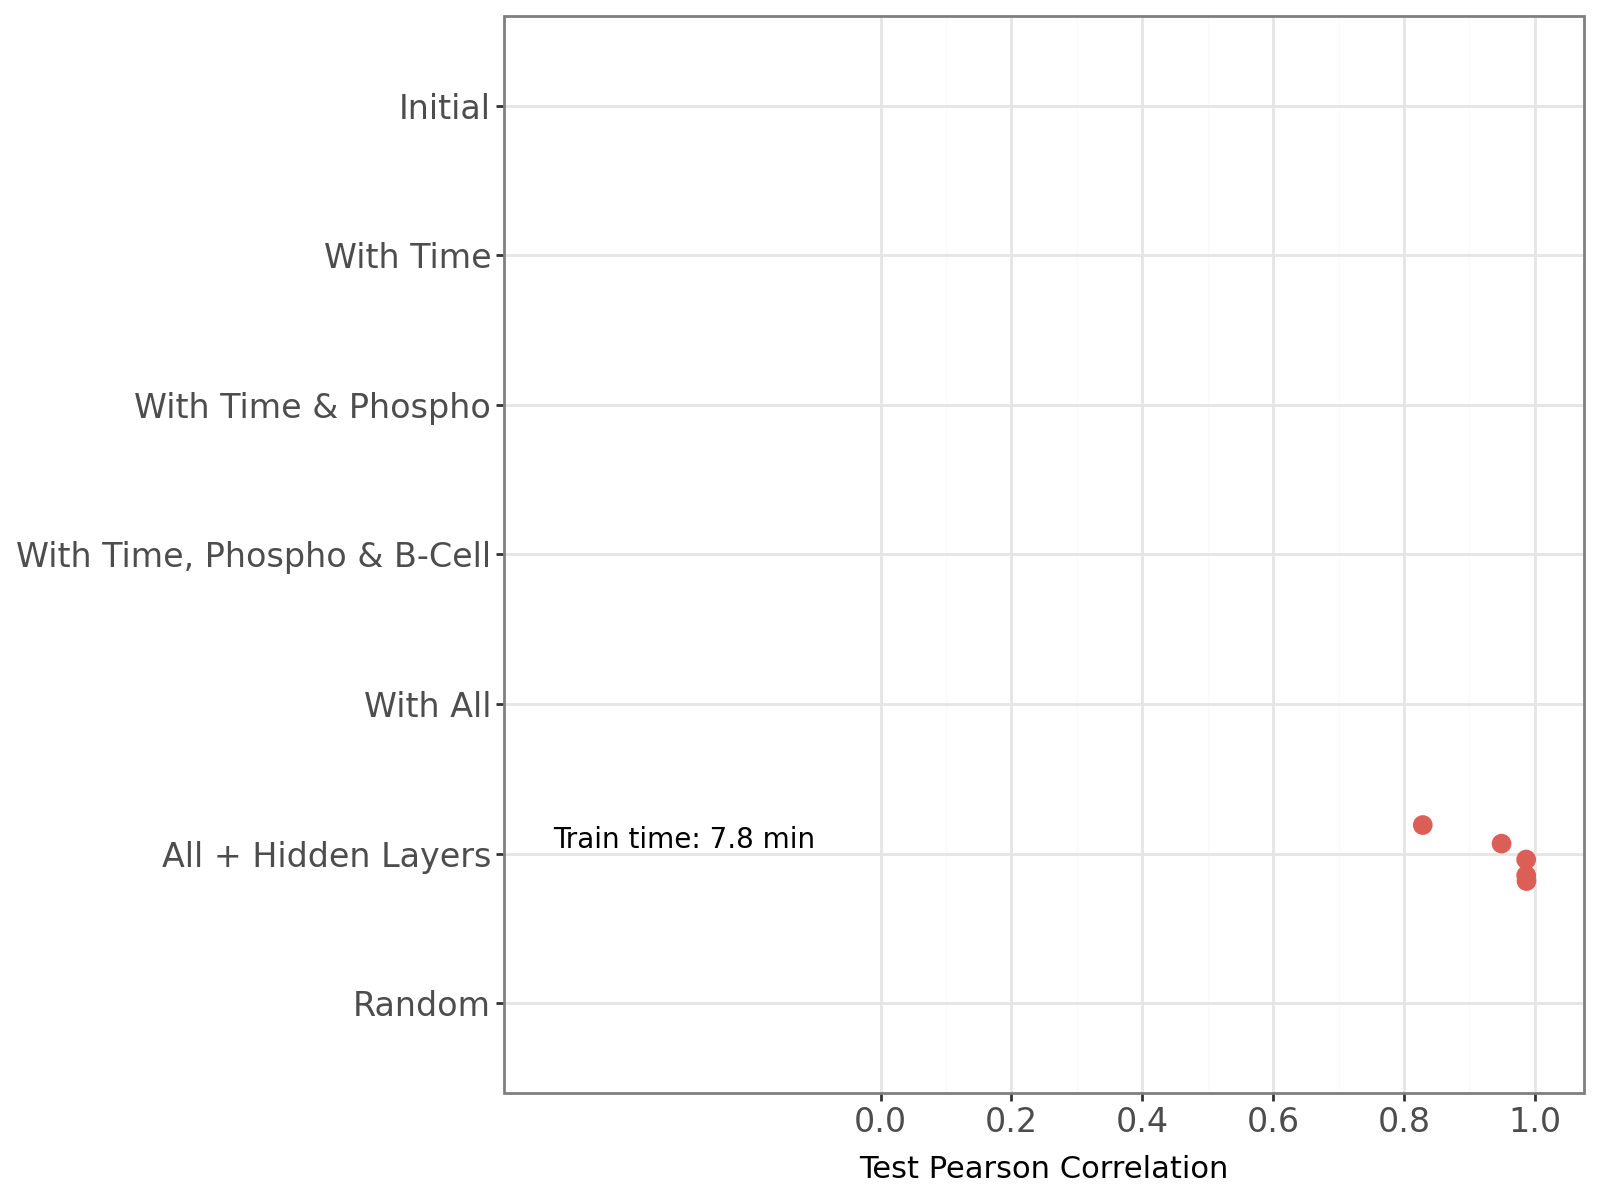

In [7]:
time_df = train_metrics_df.groupby("config", as_index=False)["training_time"].mean()
max_pearson_df = test_metrics_df.groupby("config", as_index=False)["test_pearson"].max()

annot_df = pd.merge(time_df, max_pearson_df, on="config")
annot_df["label"] = "Train time: " + (annot_df["training_time"] / 60).round(1).astype(str) + " min"
annot_df["xpos"] = -0.3

config_order = [
    "random",
    "with_all_hiddenlayers_in_cell",
    "with_all",
    "with_time_with_phospho_with_bcell",
    "with_time_with_phospho",
    "with_time",
    "initial"
]
config_labels = {
    "with_all_hiddenlayers_in_cell": "All + Hidden Layers",
    "with_all": "With All",
    "with_time_with_phospho_with_bcell": "With Time, Phospho & B-Cell",
    "with_time_with_phospho": "With Time & Phospho",
    "with_time": "With Time",
    "initial": "Initial",
    "random": "Random"
}

p = (p9.ggplot(test_metrics_df, p9.aes(x="test_pearson", y="config"))
     + p9.geom_jitter(p9.aes(color="config"), width=0, height=0.2, size=3)
     + p9.geom_text(data=annot_df, mapping=p9.aes(x="xpos", y="config", label="label"), 
                 size=10, va="bottom")
     + p9.labs(x="Test Pearson Correlation",
            y="")
     + p9.scale_x_continuous(limits=(-0.5, 1), breaks=np.arange(0, 1.01, 0.2))
     + p9.scale_y_discrete(limits=config_order, labels=config_labels)
     + p9.theme_bw()
     + p9.theme(figure_size=(8, 6),
             axis_text_y=p9.element_text(size=12),
             axis_text_x=p9.element_text(size=12),
             legend_position="none")
    )

print(p)